In [14]:
from datasets import load_dataset,Dataset
import torch
import os
import random
import numpy as np
from tqdm import tqdm
import json
import argparse
import logging
from transformers import AutoTokenizer, AutoModelForSequenceClassification,Trainer
from pprint import pprint
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import DataLoader
from tqdm import tqdm
from collections import Counter

#fix random seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)



## Load model and tokenizer

In [15]:


tokenizer = AutoTokenizer.from_pretrained("tum-nlp/bert-hateXplain")
model = AutoModelForSequenceClassification.from_pretrained("tum-nlp/bert-hateXplain",output_attentions=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=0)
      (position_embeddings): Embedding(512, 256)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=256, out_features=256, bias=True)
              (LayerNorm): LayerNorm((256,), eps=1e-1

In [16]:
def get_predictions(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = torch.softmax(logits, dim=1)
    predictions = torch.argmax(probs, dim=1).cpu().numpy()
    return predictions, probs.cpu().numpy(),outputs.attentions,inputs

pred,prob,Att,inputs= get_predictions("You are stupid monkeys ")



In [17]:
def get_token_values(inputs, special_tokeens=True):
    # Convert input_ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
    # Remove special tokens
    tokens = [token for token in tokens if token not in tokenizer.all_special_tokens or special_tokeens==True]
    return tokens

def print_attention_map_per_head(attention_map, tokens,title=True):
    # attention_map: (num_heads, seq_len, seq_len)
    # tokens: list of tokens in the input text
    num_heads = attention_map.shape[0]

    vmin = attention_map.min().item()
    vmax = attention_map.max().item()

    fig, axes = plt.subplots(1, num_heads, figsize=(7*num_heads, 5), squeeze=False)
    axes = axes[0]

    for i in range(num_heads):
        im = axes[i].matshow(attention_map[i].cpu().numpy(), cmap='hot', vmin=vmin, vmax=vmax)
        axes[i].set_xticks(range(len(tokens)))
        axes[i].set_yticks(range(len(tokens)))
        axes[i].set_xticklabels(tokens, rotation=45)
        axes[i].set_yticklabels(tokens)
        if title:
            axes[i].set_title(f'Head {i+1}')

    # Create a single colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    cbar.set_label('Attention Weight')
    plt.show()
    return


In [18]:
at=torch.stack(Att).squeeze(1)
print(at.shape)

torch.Size([4, 4, 6, 6])


Attention per layer and head:


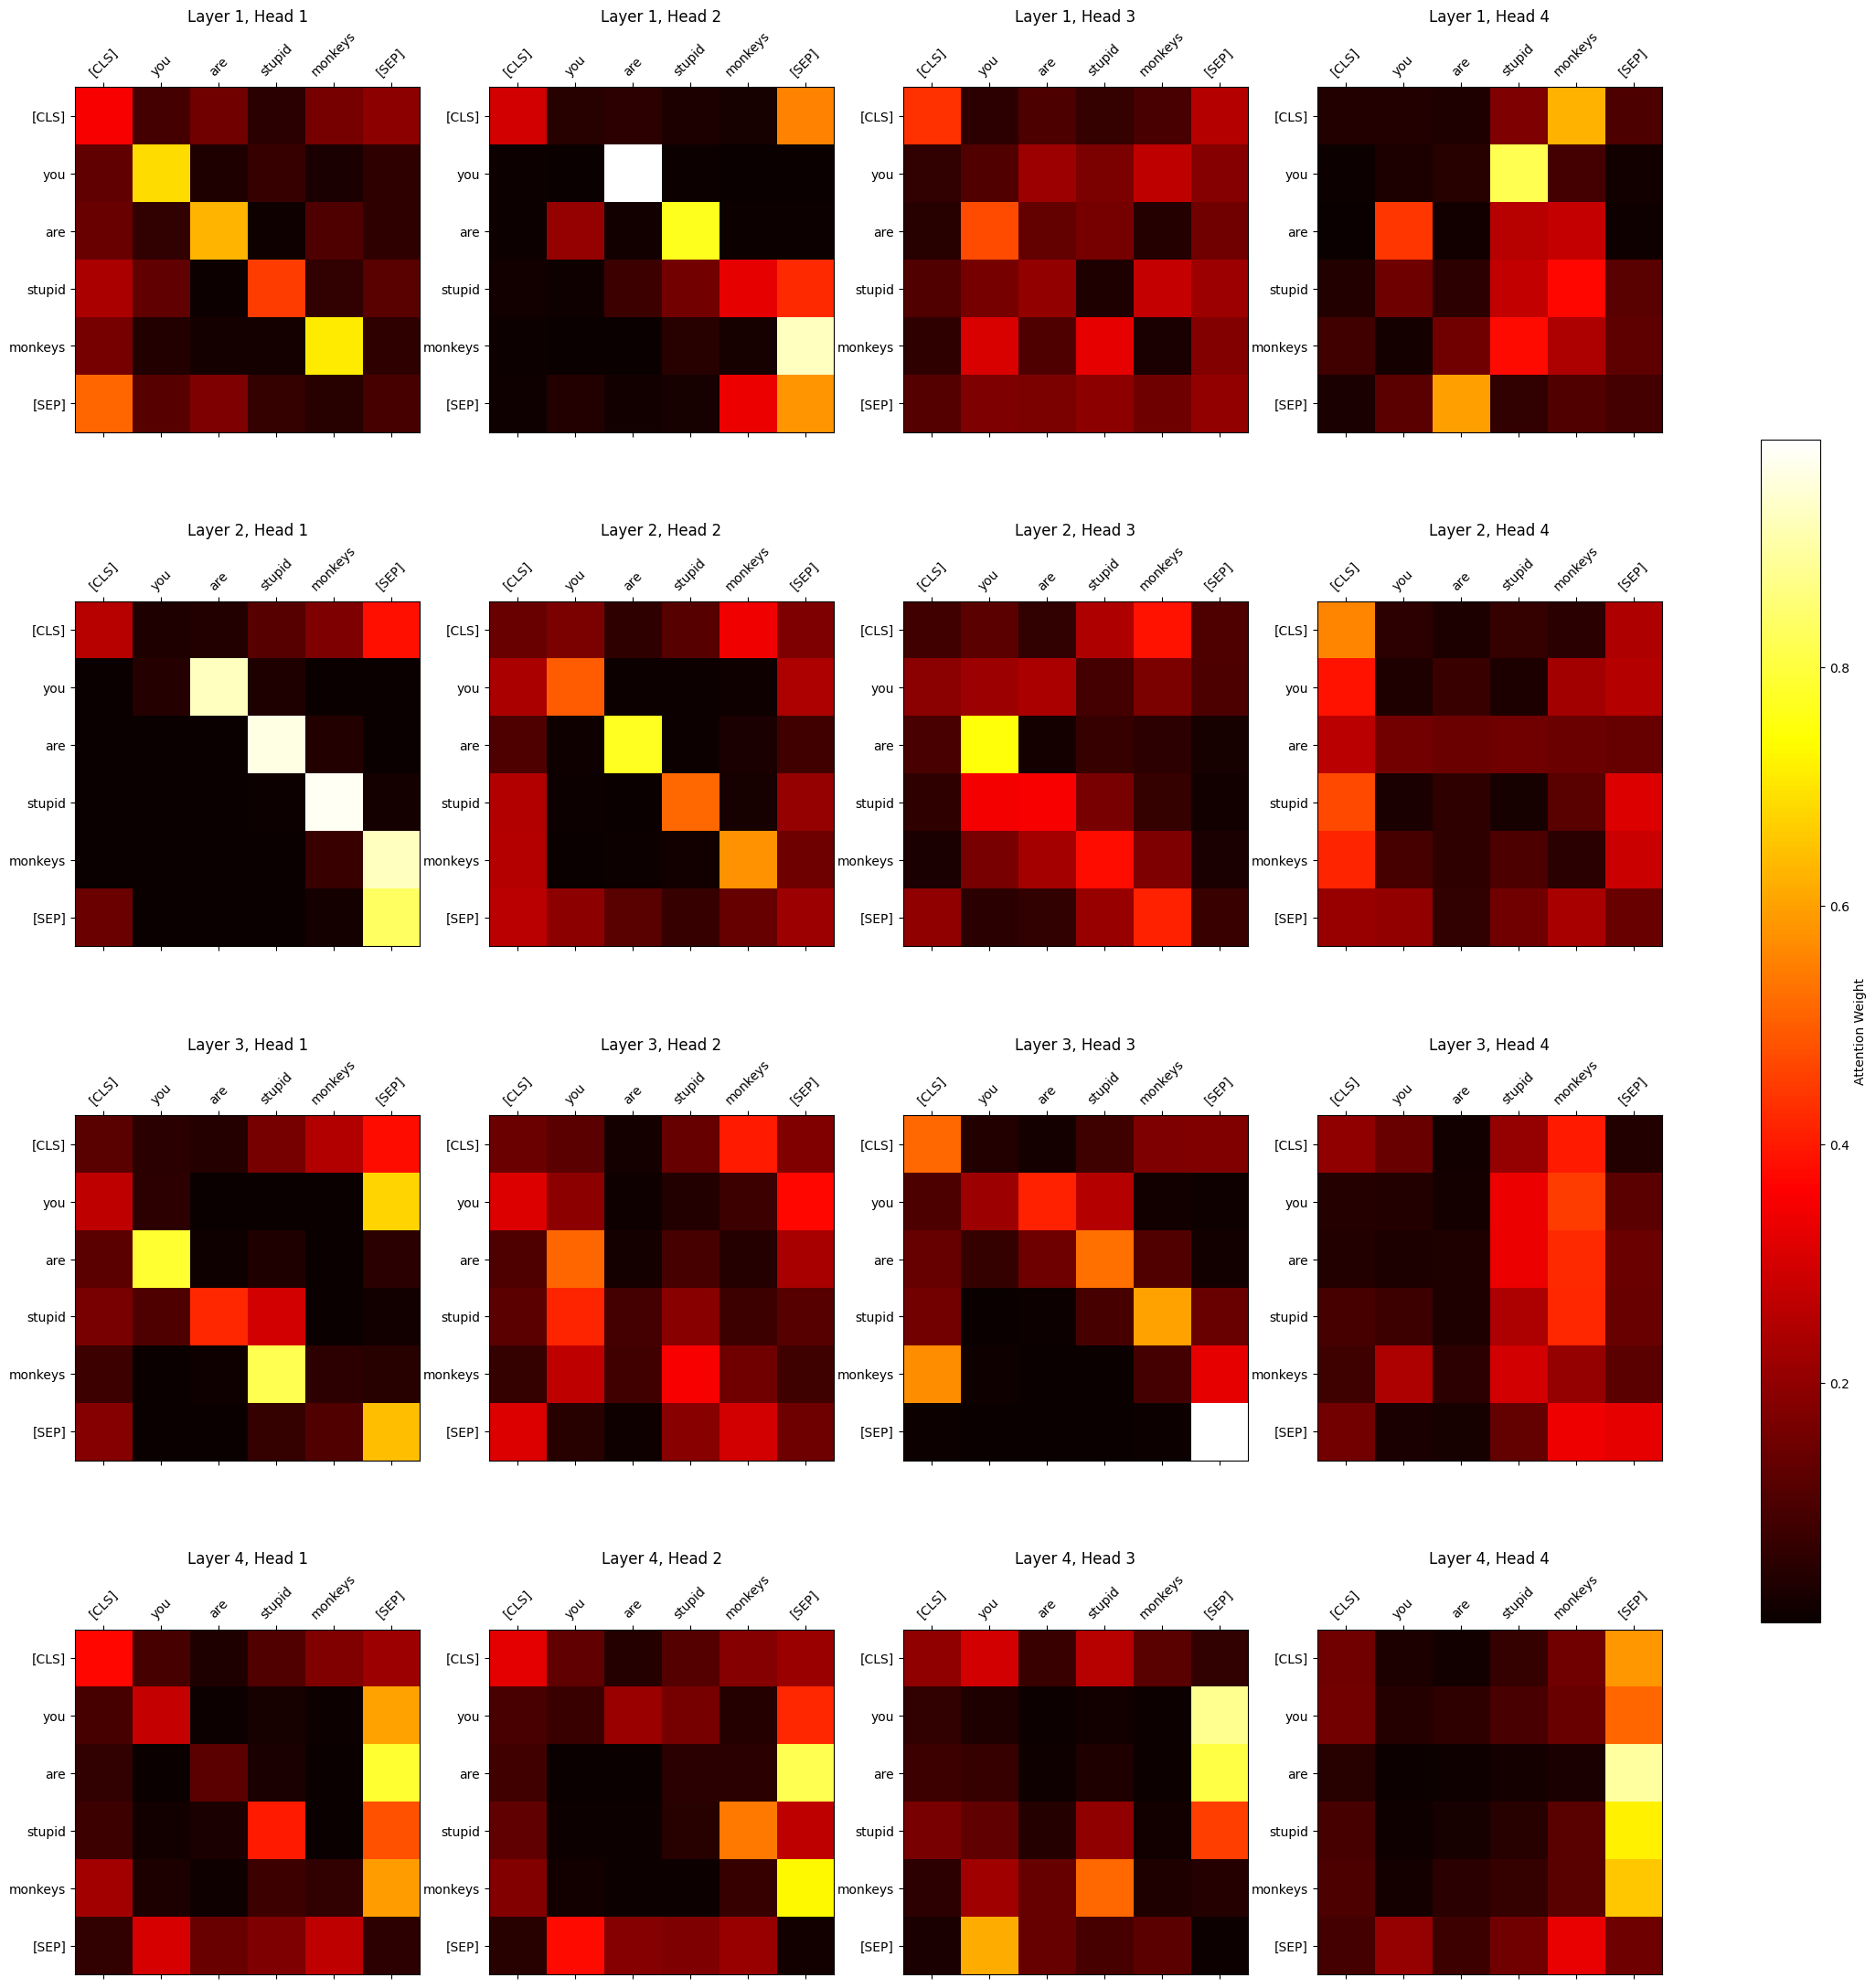

Attention per head (mean across layers):


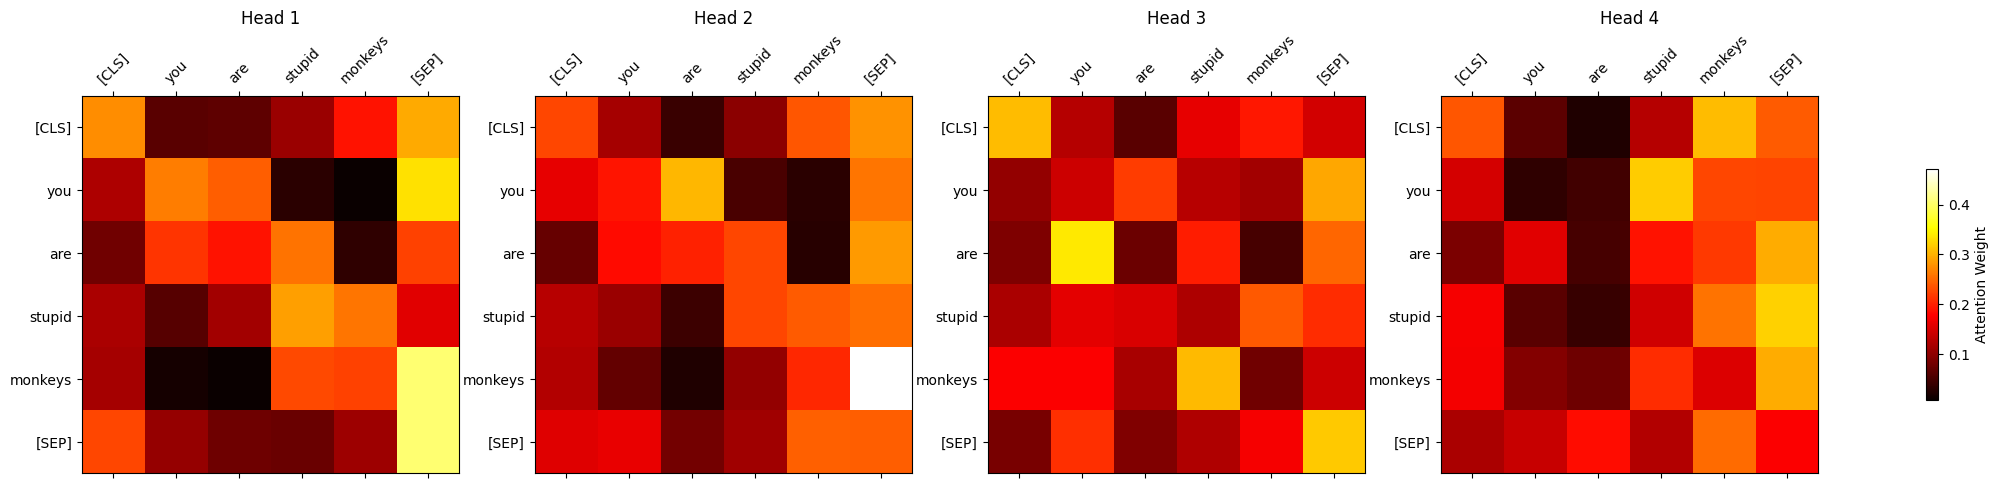

Attention per layer (mean across heads):


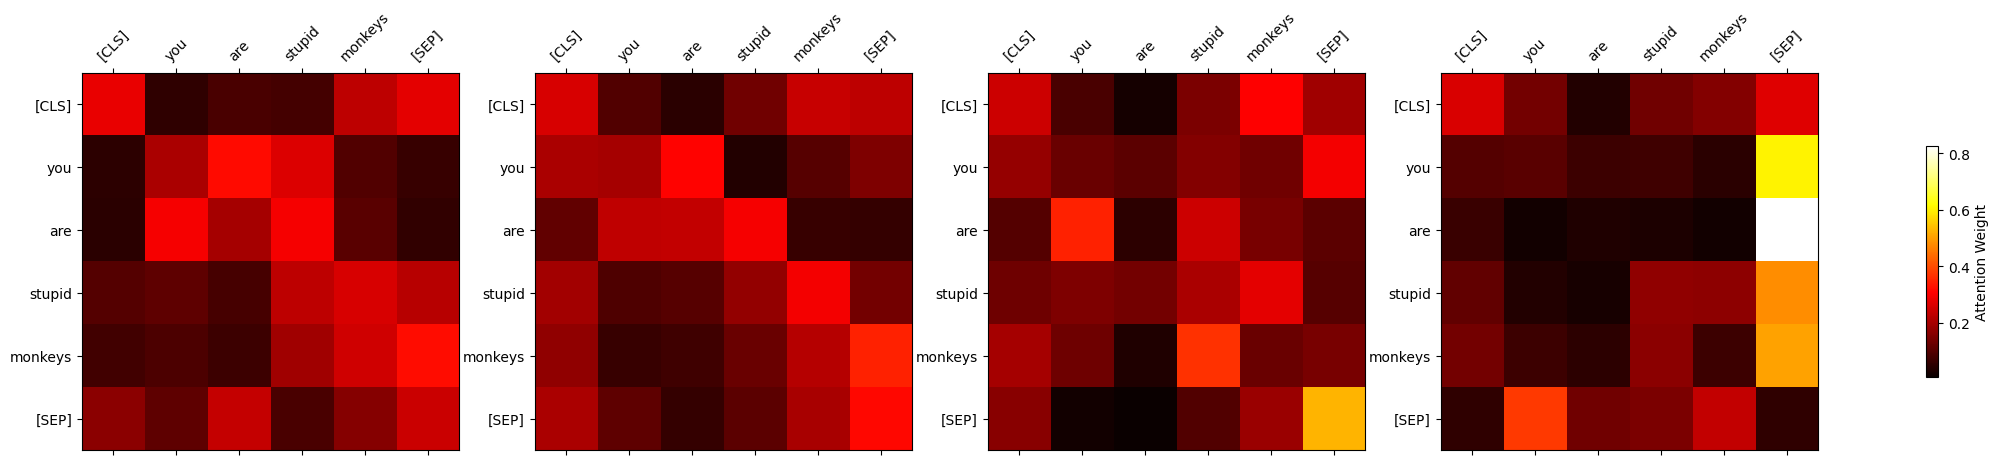

Attention mean (mean across heads and layers):


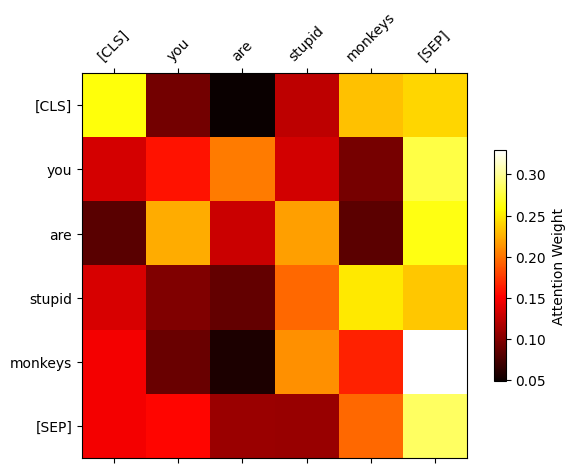

Mean attention across all heads and layers per token:
tensor([0.1510, 0.1362, 0.1059, 0.1651, 0.1698, 0.2720], device='cuda:0')


In [19]:
def print_attention_per_layer_and_head(attentions, tokens):
    # attentions: (num_layers, num_heads, seq_len, seq_len)
    num_layers, num_heads = attentions.shape[:2]
    vmin = attentions.min().item()
    vmax = attentions.max().item()

    fig, axes = plt.subplots(num_layers, num_heads, figsize=(7*num_heads, 7*num_layers), squeeze=False)

    for layer in range(num_layers):
        for head in range(num_heads):
            ax = axes[layer][head]
            im = ax.matshow(attentions[layer][head].cpu().numpy(), cmap='hot', vmin=vmin, vmax=vmax)
            ax.set_xticks(range(len(tokens)))
            ax.set_yticks(range(len(tokens)))
            ax.set_xticklabels(tokens,rotation=45)
            ax.set_yticklabels(tokens)
            ax.set_title(f'Layer {layer+1}, Head {head+1}')

    # Create a single colorbar
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
    cbar.set_label('Attention Weight')
    plt.show()

print("Attention per layer and head:")
print_attention_per_layer_and_head(at, get_token_values(inputs))
print("Attention per head (mean across layers):")
print_attention_map_per_head(at.mean(0), get_token_values(inputs))
print("Attention per layer (mean across heads):")
print_attention_map_per_head(at.mean(1), get_token_values(inputs), title=False)
print("Attention mean (mean across heads and layers):")
print_attention_map_per_head(at.mean((0,1)).unsqueeze(0), get_token_values(inputs),False)
print("Mean attention across all heads and layers per token:")
print(at.mean((0,1,2)).squeeze(0))


Compute the most attended tokens in the dataset

In [20]:
def extract_token_attention_with_context(
    attentions,
    attention_mask,
    input_ids,
    tokenizer,
    specific_token=None,
    per_layer=False,
    per_head=False,
    context_window=1
):
    """
    Extracts the most attended-to token (excluding [CLS], [SEP], [PAD]) and returns
    its context window converted to actual tokens.

    Args:
        attentions (List[Tensor]): List of attention tensors per layer (shape: [batch, heads, seq, seq])
        attention_mask (Tensor): Attention mask [batch, seq] where 1=valid, 0=padded
        input_ids (Tensor): Input token IDs [batch, seq]
        tokenizer: Tokenizer to convert IDs to tokens
        specific_token (int): Index of source token to examine (e.g., 0 for [CLS])
        per_layer (bool): Return per layer results
        per_head (bool): Return per head results
        context_window (int): Number of tokens before/after target token to include

    Returns:
        List[List[str]]: For each batch item, list of context tokens around most attended token
    """

    # Step 1: Stack and reshape attention tensors
    attn = torch.stack(attentions, dim=0)  # [layers, batch, heads, seq, seq]
    layers, batch_size, num_heads, seq_len, _ = attn.shape

    # Step 2: Create mask for valid tokens (exclude special tokens and padding)
    cls_id = tokenizer.cls_token_id if hasattr(tokenizer, 'cls_token_id') else tokenizer.convert_tokens_to_ids('[CLS]')
    sep_id = tokenizer.sep_token_id if hasattr(tokenizer, 'sep_token_id') else tokenizer.convert_tokens_to_ids('[SEP]')
    pad_id = tokenizer.pad_token_id if hasattr(tokenizer, 'pad_token_id') else tokenizer.convert_tokens_to_ids('[PAD]')

    # Create mask for valid target tokens (exclude CLS, SEP, PAD)
    valid_token_mask = (
        (input_ids != cls_id) &
        (input_ids != sep_id) &
        (input_ids != pad_id) &
        (attention_mask.bool())
    )  # [batch, seq]

    # Step 3: Extract attention scores based on source token
    if specific_token is not None:
        if not (0 <= specific_token < seq_len):
            raise ValueError(f"Token position {specific_token} is outside sequence length {seq_len}")
        # Get attention from specific source token to all targets
        attn_scores = attn[..., specific_token, :]  # [layers, batch, heads, seq]
    else:
        # Average attention across all source tokens (mean of each row)
        attn_scores = attn.mean(dim=-2)  # [layers, batch, heads, seq]

    # Step 4: Apply valid token mask to attention scores
    # Expand mask to match attention scores shape
    valid_mask_expanded = valid_token_mask.unsqueeze(0).unsqueeze(2)  # [1, batch, 1, seq]
    valid_mask_expanded = valid_mask_expanded.expand(layers, batch_size, num_heads, seq_len)

    # Mask invalid tokens with very low attention
    masked_attn_scores = attn_scores.masked_fill(~valid_mask_expanded, float('-inf'))

    # Step 5: Find most attended token indices
    max_vals, max_indices = masked_attn_scores.max(dim=-1)  # [layers, batch, heads]

    # Step 6: Reduce dimensions based on requirements
    if not per_layer and not per_head:
        # Average across layers and heads
        max_indices = max_indices.float().mean(dim=(0, 2)).long()  # [batch]
    elif per_layer and not per_head:
        # Average across heads only
        max_indices = max_indices.float().mean(dim=2).long()  # [layers, batch]
    elif not per_layer and per_head:
        # Average across layers only
        max_indices = max_indices.float().mean(dim=0).long()  # [batch, heads]
    # else: keep full [layers, batch, heads] shape

    # Step 7: Extract context for each batch item
    contexts = []

    for batch_idx in range(batch_size):
        # Get the target token index for this batch item
        if max_indices.dim() == 1:  # [batch] case
            target_idx = max_indices[batch_idx].item()
        elif max_indices.dim() == 2:
            if max_indices.size(0) == batch_size:  # [batch, heads] case
                target_idx = max_indices[batch_idx].float().mean().long().item()
            else:  # [layers, batch] case
                target_idx = max_indices[:, batch_idx].float().mean().long().item()
        else:  # [layers, batch, heads] case
            target_idx = max_indices[:, batch_idx, :].float().mean().long().item()

        # Extract context window around target token
        start_idx = max(0, target_idx - context_window)
        end_idx = min(seq_len, target_idx + context_window + 1)

        # Get token IDs in context window
        context_token_ids = input_ids[batch_idx, start_idx:end_idx]

        # Convert to tokens, but only include non-padded tokens
        context_tokens = []
        for token_id in context_token_ids:
            toks=[]
            if token_id not in [pad_id,sep_id,cls_id]:  # Skip padding tokens
                toks.append(token_id)
        contxt= tokenizer.decode(toks)


        contexts.append(contxt)

    return contexts

# Import Dataset

In [ ]:



with open('../Data/dataset.json', 'r') as f:
    data = json.load(f)

keys = list(data.keys())

with open('../Data/post_id_divisions.json', 'r') as f:
    divisions = json.load(f)

data={key:data[key] for key in divisions["train"]}

In [22]:



def resolve_disagreements_custom(dataset, disagreement_stats):
    resolved = []
    counter_unanimous = 0
    counter_hatespeech = 0
    counter_off_normal = 0
    counter_skipped = 0

    for post_id, disagreement, label_counts in disagreement_stats:
        if disagreement == 3:
            counter_skipped += 1
            continue  # skip level 3 disagreements

        text = " ".join(dataset[post_id]['post_tokens'])
        labels = list(label_counts.elements())
        label_set = set(label_counts.keys())

        # Case 1: unanimous
        if disagreement == 1:
            counter_unanimous += 1
            resolved_label = labels[0]

        # Case 2: offensive vs hatespeech → resolve as hatespeech
        elif disagreement == 2 and label_set == {"offensive", "hatespeech"}:
            counter_hatespeech += 1
            resolved_label = "hatespeech"

        # Case 3: normal vs offensive or normal vs hatespeech → majority
        else:
            counter_off_normal += 1
            resolved_label = Counter(labels).most_common(1)[0][0]

        resolved.append((text, resolved_label))

    print(f"Unanimous: {counter_unanimous}, Offensive vs Hatespeech: {counter_hatespeech}, Normal vs Other: {counter_off_normal}, Skipped (3-label): {counter_skipped}")
    return resolved

def compute_annotator_disagreement(dataset, verbose=False, return_top_n=0, plot=False):
    """
    Compute the number of unique labels assigned by annotators for each post,
    and optionally plot disagreement distribution.

    Args:
        dataset (dict): Loaded JSON dataset
        verbose (bool): Print summary stats
        return_top_n (int): If >0, return top N most disagreed examples
        plot (bool): If True, plot a histogram of disagreement levels

    Returns:
        disagreement_stats (list of tuples): (post_id, disagreement_count, label_counter)
        top_disagreements (optional): top N posts with highest disagreement
    """
    disagreement_stats = []

    for post_id, content in dataset.items():
        labels = [ann['label'] for ann in content.get('annotators', [])]
        label_counter = Counter(labels)
        disagreement_count = len(label_counter)
        disagreement_stats.append((post_id, disagreement_count, label_counter))

    if verbose:
        total = len(disagreement_stats)
        unanimous = sum(1 for _, c, _ in disagreement_stats if c == 1)
        mild_disagreement = sum(1 for _, c, _ in disagreement_stats if c == 2)
        full_disagreement = sum(1 for _, c, _ in disagreement_stats if c >= 3)

        print(f"Total examples: {total}")
        print(f"Unanimous (all annotators agree): {unanimous} ({unanimous/total:.2%})")
        print(f"Two-label disagreement: {mild_disagreement} ({mild_disagreement/total:.2%})")
        print(f"Three-label disagreement: {full_disagreement} ({full_disagreement/total:.2%})")

    if plot:
        disagreement_counts = [c for _, c, _ in disagreement_stats]
        count_dist = Counter(disagreement_counts)
        plt.bar(count_dist.keys(), count_dist.values(), color='gray')
        plt.xlabel("Number of unique labels (Disagreement level)")
        plt.ylabel("Number of posts")
        plt.title("Annotator Disagreement Distribution")
        plt.xticks([1, 2, 3])
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    if return_top_n > 0:
        top_disagreements = sorted(disagreement_stats, key=lambda x: -x[1])[:return_top_n]
        return disagreement_stats, top_disagreements

    return disagreement_stats


disagreement_stat=compute_annotator_disagreement(data)
resolved_data = resolve_disagreements_custom(data, disagreement_stat)

dataset=Dataset.from_dict({
    'text': [item[0] for item in resolved_data],
    'label': [item[1] for item in resolved_data],
    
})




def is_hateful_or_offensive(example):
    valid_labels=["hatespeech","offensive"] #We focus on hatespeech only, we can add "offensive" if needed
    if not example["label"]:
        return False
    lab=example["label"]

    return lab in valid_labels

hate_filtered=dataset.filter(is_hateful_or_offensive)


def tokenize(example):
    ''''
    Tokenizes the input text using the provided tokenizer.
    '''

    return tokenizer(example["text"],padding="max_length")

hate_dataset = hate_filtered.map(tokenize,batched=True)



Unanimous: 7888, Offensive vs Hatespeech: 3124, Normal vs Other: 4371, Skipped (3-label): 0


Filter:   0%|          | 0/15383 [00:00<?, ? examples/s]

Map:   0%|          | 0/9132 [00:00<?, ? examples/s]

Load in torch format

In [23]:
hate_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
hate_load=DataLoader(hate_dataset,batch_size=60)
#hate_dataset["attention_mask"]

We compute here the list of the most attended tokens without padding context. The attention score is obtained by averaging all the 16 attention weights matrices (4 heads,4 layers). We look at the biggest score related to the class predictor token. This is computed on the train data only.

In [ ]:
best_att=Counter()


with torch.no_grad():
    for inp in tqdm(hate_load):
        input_ids=inp["input_ids"].to(device)
        attention_mask=inp['attention_mask'].to(device)
        outputs = model(input_ids=input_ids,attention_mask=attention_mask,output_attentions=True)
        Max_attentions_tok_ctxt=extract_token_attention_with_context(outputs.attentions,attention_mask,input_ids,tokenizer,0,context_window=0) #most attended token/word here we have token as no context window is given +  context +- 0
        best_att.update(Max_attentions_tok_ctxt)




100%|██████████| 153/153 [00:14<00:00, 10.50it/s]


In [25]:
A=best_att.most_common()
print("Most attended tokens with context:" + str(A[:10]))


Most attended tokens with context:[('the', 249), ('a', 199), ('and', 181), ('##gger', 171), ('to', 141), ('ni', 136), ('##s', 134), ('are', 109), ('in', 105), ('you', 101)]


In [ ]:
def save_attended_context(Top_ctxt,path):
  ctxt=[]
  for rank,(Word,count) in enumerate(Top_ctxt):
        ctxt.append({"rank":rank,"word":Word,"count":count})
  with open(path,"w") as f:
    json.dump(ctxt,f)

save_attended_context(A,"No_test_Full_Hate_Offe_[class]_0tok.json")

